# Efficient Net B1

This work was realized as part of the capstone project of the MS in Data Science at Pace University by Lolyna de la Fuente Ordaz

### Data Loading and Inspection

In [1]:
# Libraries and Dependencies

# Data Manipulation & Analysis
import pandas as pd
import numpy as np
from pathlib import Path

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image
from PIL import Image as pil_image


# Machine Learning & Deep Learning
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from torch import nn
import pytorch_lightning as pl
from torchsummary import summary
import torchvision.models as models
from torch.utils.data import DataLoader
from efficientnet_pytorch import EfficientNet

# Metrics & Evaluation
from sklearn.metrics import mean_squared_error

# Progress Monitoring
from tqdm import tqdm

# Warning & Error Handling
import warnings
warnings.filterwarnings("ignore")

# Model Checkpoints & Logging
from pytorch_lightning import loggers

c:\Users\lolyn\anaconda3\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] No se encontró el proceso especificado'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Loading the training dataset into a Pandas Data Frame

All datasets were downloaded using the accessdata.py

In [2]:
# Reading our databases
train_metadata = pd.read_csv(r"data\training_set_features.csv")
train_labels = pd.read_csv(r"data\training_set_labels.csv")

### Merging Metadata with Labels Dataset

In [3]:
# Merge train_metadata with train_labels on the image_id field
full_metadata = train_metadata.merge(train_labels, on="Image_ID")

## 2. Images

We add a file_name column to our training metadata, which will contain a Path object with the full path to our data.

In [4]:
# Convert 'train' to a Path object and concatenate the file names correctly
full_metadata["file_name"] = (
    Path("train") / (full_metadata["Image_ID"].astype(str) + ".jpg")
)

## 3. Model for Analysis

In [5]:
# Add a temporary column for number of images per storm
images_per_storm = full_metadata.groupby("Storm_ID").size().to_frame("images_per_storm")
full_metadata = full_metadata.merge(images_per_storm, how="left", on="Storm_ID")

In [6]:
# Each storm is sorted by relative time
# Identify the final 20% of images per storm
full_metadata["pct_of_storm"] = (
    full_metadata.groupby("Storm_ID").cumcount() / full_metadata.images_per_storm
)
train = full_metadata[full_metadata.pct_of_storm < 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)
val = full_metadata[full_metadata.pct_of_storm >= 0.8].drop(
    ["images_per_storm", "pct_of_storm"], axis=1
)

In [7]:
# Confirm pct of images in the validation set is approximately 20%
len(val) / len(full_metadata) * 100

19.734688358455386

In [8]:
# Sample 10% to increase performance
train = train.sample(frac=0.1, replace=False, random_state=1)
val = val.sample(frac=0.1, replace=False, random_state=1)

In [9]:
train.shape

(5639, 6)

In [10]:
val.shape

(1386, 6)

### Splitting the Data

In [11]:
# Separate features from labels
x_train = train.drop("Wind_Speed", axis=1)
y_train = train.Wind_Speed

x_val = val.drop("Wind_Speed", axis=1)
y_val = val.Wind_Speed

### Building the Model

In [12]:
class DatasetWIND(Dataset):
    """Reads in an image, transforms pixel values, and serves
    a dictionary containing the image id, image tensors, and label.
    """
    def __init__(self, x_train, y_train=None):
        self.data = x_train
        self.label = y_train
        self.transform = transforms.Compose(
            [
                transforms.CenterCrop(128),
                transforms.ToTensor(),
                # All models expect the same normalization mean & std
                # https://pytorch.org/docs/stable/torchvision/models.html
                transforms.Normalize(
                    mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)
                ),
            ]
        )

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        image = pil_image.open(self.data.iloc[index]["file_name"]).convert("RGB")
        image = self.transform(image)
        image_id = self.data.iloc[index]["Image_ID"]
        
        if self.label is not None:
            label = float(self.label.iloc[index])
            sample = {"Image_ID": image_id, "image": image, "label": label}
        else:
            sample = {
                "Image_ID": image_id,
                "image": image,
            }
        return sample

In [13]:
class RMSELoss(nn.Module):
    """Measures Root Mean Square Error"""

    def __init__(self):
        super(RMSELoss, self).__init__()
        self.mse = nn.MSELoss()

    def forward(self, pred, true):
        return torch.sqrt(self.mse(pred, true))

In [14]:
class PretrainedWindModel(pl.LightningModule):
    def __init__(self, hparams):
        super(PretrainedWindModel, self).__init__()

        self.save_hyperparameters(hparams)
        self.learning_rate = self.hparams.get("lr", 2e-4)
        self.hidden_size = self.hparams.get("embedding_dim", 50)
        self.dropout = self.hparams.get("dropout", 0.1)
        self.max_epochs = self.hparams.get("max_epochs", 1)
        self.num_workers = self.hparams.get("num_workers", 0)
        self.batch_size = self.hparams.get("batch_size", 10)
        self.x_train = self.hparams.get("x_train")
        self.y_train = self.hparams.get("y_train")
        self.x_val = self.hparams.get("x_val")
        self.y_val = self.hparams.get("y_val")
        self.num_outputs = 1  # One prediction for regression

        # Where the final model will be saved
        self.output_path = Path.cwd() / self.hparams.get("output_path", "model-outputs")
        self.output_path.mkdir(exist_ok=True)

        # Instantiating our training and validation datasets
        self.train_dataset = DatasetWIND(self.x_train, self.y_train)
        self.val_dataset = DatasetWIND(self.x_val, self.y_val)
        self.model = self.prepare_model()
    
    def prepare_model(self):
        efficientnet_model = EfficientNet.from_pretrained('efficientnet-b1')

        # Change the final classification layer to a regression output
        efficientnet_model._fc = nn.Sequential(
            nn.Linear(1280, self.hidden_size),  # 1280 is the output size from EfficientNet
            nn.ReLU(inplace=True),
            nn.Dropout(self.dropout),
            nn.Linear(self.hidden_size, self.num_outputs)  # Output 1 value for regression
        )

        return efficientnet_model


    def forward(self, image):
        output = self.model(image)  # Shape should be (batch_size, 1) after modification
        return output.squeeze()  # Remove the extra dimension, resulting in shape (batch_size,)

    def training_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"].type(torch.FloatTensor).squeeze()  # Ensure labels are (batch_size,)
        
        criterion = RMSELoss()
        predictions = self.model(x).squeeze()  # Ensure the model output is (batch_size,)
        
        #print(f"Predictions shape: {predictions.shape}, Labels shape: {y.shape}")  # Debugging line
        
        loss = criterion(predictions, y)
        
        tensorboard_logs = {"train_loss": loss}
        self.log("train_loss", loss)
        
        return {"loss": loss, "log": tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        x = batch["image"]
        y = batch["label"].type(torch.FloatTensor).squeeze()  # Ensure labels are (batch_size,)
        
        criterion = RMSELoss()
        predictions = self.model(x).squeeze()  # Ensure the model output is (batch_size,)
        
        #print(f"Predictions shape: {predictions.shape}, Labels shape: {y.shape}")  # Debugging line
        
        loss = criterion(predictions, y)
        
        tensorboard_logs = {"val_loss": loss}
        self.log("val_loss", loss)
        
        return {"batch_val_loss": loss, "log": tensorboard_logs}


    def train_dataloader(self):
        return DataLoader(self.train_dataset, num_workers=self.num_workers, batch_size=self.batch_size)

    def val_dataloader(self):
        return DataLoader(self.val_dataset, num_workers=self.num_workers, batch_size=self.batch_size)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.model.parameters(), lr=self.learning_rate)

    def on_train_epoch_end(self):
        # The trainer automatically tracks losses, so you can log them easily
        avg_train_loss = self.trainer.logged_metrics.get('train_loss', None)
        if avg_train_loss:
            self.log("avg_epoch_train_loss", avg_train_loss)

    def on_validation_epoch_end(self):
        # Automatically collects validation losses and log them
        avg_val_loss = self.trainer.logged_metrics.get('val_loss', None)
        if avg_val_loss:
            self.log("avg_epoch_val_loss", avg_val_loss)
        else:
            self.log("avg_epoch_val_loss", 0.0)

    def make_submission_frame(self, x_test):
        """
        This function generates a submission frame based on the test data.
        Assumes the test data (x_test) is a DataFrame with an 'image_id' column.
        It uses the model to predict the wind speed for each test image.
        """
        test_dataset = DatasetWIND(x_test)
        test_dataloader = DataLoader(
            test_dataset, num_workers=self.num_workers, batch_size=self.batch_size
        )
        
        submission_frame = pd.DataFrame(index=x_test.Image_ID, columns=["Wind_Speed"])
        
        # Setting the model to evaluation mode for inference
        self.eval()
        
        for batch in tqdm(test_dataloader, total=len(test_dataloader)):
            x = batch["image"]
            preds = self.forward(x)  # Performs inference
            submission_frame.loc[batch["Image_ID"], "Wind_Speed"] = preds.detach().cpu().numpy().squeeze()
        
        submission_frame.Wind_Speed = submission_frame.Wind_Speed.astype(float)
        return submission_frame


### Fitting the Model

In [15]:
hparams = {
    # Required hparams
    "x_train": x_train,  # Training dataset (features)
    "y_train": y_train,  # Training dataset (labels)
    "x_val": x_val,      # Validation dataset (features)
    "y_val": y_val,      # Validation dataset (labels)

    # Optional hparams
    "lr": 2e-4,           # Learning rate for the optimizer
    "embedding_dim": 100,  # Dimensionality of the embedding (hidden size)
    "dropout": 0.1,        # Dropout rate for regularization
    "max_epochs": 4,       # Maximum number of epochs to train the model
    "batch_size": 10,      # Batch size for training
    "num_workers": 0,      # Number of CPU workers for loading data
    "gradient_clip_val": 1,  # Value for gradient clipping (helps prevent exploding gradients)
    "val_sanity_checks": 0,  # Number of sanity checks for validation (usually 0)
    "output_path": "model-outputs",  # Directory where the trained model will be saved
    "log_path": "logs",          # Directory where TensorBoard logs will be saved
}

In [16]:
# Creating a logger instance
logger = loggers.TensorBoardLogger("logs", name="benchmark_model")

# Initializing the model with hparams
storm_model = PretrainedWindModel(hparams=hparams)

# Initializing the Trainer with the logger
trainer = pl.Trainer(
    max_epochs=hparams['max_epochs'],
    default_root_dir=hparams['output_path'],
    logger=logger,  # Pass the logger here
    callbacks=[
        pl.callbacks.ModelCheckpoint(
            dirpath=hparams['output_path'], 
            monitor="avg_epoch_val_loss", 
            mode="min", 
            verbose=True
        )
    ],
    gradient_clip_val=hparams["gradient_clip_val"],
    num_sanity_val_steps=hparams["val_sanity_checks"],
)

# Fitting the model
trainer.fit(storm_model)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


Loaded pretrained weights for efficientnet-b1



  | Name  | Type         | Params | Mode 
-----------------------------------------------
0 | model | EfficientNet | 6.6 M  | train
-----------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params
26.566    Total estimated model params size (MB)
355       Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 0, global step 564: 'avg_epoch_val_loss' reached 12.60712 (best 12.60712), saving model to 'C:\\Users\\lolyn\\OneDrive\\Escritorio\\CS668\\model-outputs\\epoch=0-step=564-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 1, global step 1128: 'avg_epoch_val_loss' reached 11.79004 (best 11.79004), saving model to 'C:\\Users\\lolyn\\OneDrive\\Escritorio\\CS668\\model-outputs\\epoch=1-step=1128.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 2, global step 1692: 'avg_epoch_val_loss' reached 10.43822 (best 10.43822), saving model to 'C:\\Users\\lolyn\\OneDrive\\Escritorio\\CS668\\model-outputs\\epoch=2-step=1692-v1.ckpt' as top 1


Validation: |          | 0/? [00:00<?, ?it/s]

Epoch 3, global step 2256: 'avg_epoch_val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=4` reached.


## 4. Model Results

In [17]:
# Best checkpoint based on logs
best_checkpoint = str(Path("model-outputs") / "epoch=2-step=1692-v1.ckpt")
example_model = PretrainedWindModel.load_from_checkpoint(best_checkpoint)

Loaded pretrained weights for efficientnet-b1


In [18]:
test_metadata = pd.read_csv(r"data\test_set_features.csv")
test_metadata["file_name"] = (
    Path("test") / (test_metadata["Image_ID"].astype(str) + ".jpg")
)

### Creating our Submission.csv with the predictions

In [19]:
submission = example_model.make_submission_frame(test_metadata)
submission.to_csv('efficientnetb1.csv', index=False)

100%|██████████| 4438/4438 [15:07<00:00,  4.89it/s]


In [20]:
submission = pd.read_csv(r"efficientnetb1.csv")

In [21]:
submission.head()

,Wind_Speed
0,87.073341
1,70.221558
2,62.090458
3,75.871559
4,70.470345


In [22]:
# We need it in int so it can be like our test_labels
submission = submission.round().astype(int)
submission.head()

,Wind_Speed
0,87
1,70
2,62
3,76
4,70


In [23]:
submission.Wind_Speed.describe()

count    44377.000000
mean        45.656737
std         19.737489
min         14.000000
25%         32.000000
50%         40.000000
75%         53.000000
max        143.000000
Name: Wind_Speed, dtype: float64

## 5. Model Metrics and Evaluation

In [24]:
# We call our test_labels.csv for model evaluation
test_labels = pd.read_csv(r"data\test_set_labels.csv")

In [25]:
# Assuming 'y_true' and 'y_pred' are your true labels and predictions
y_true = test_labels['Wind_Speed'] # True values
y_pred = submission['Wind_Speed']  # Predicted values

mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)

print(f"RMSE: {rmse}")

RMSE: 11.958185366699608


### Visualization

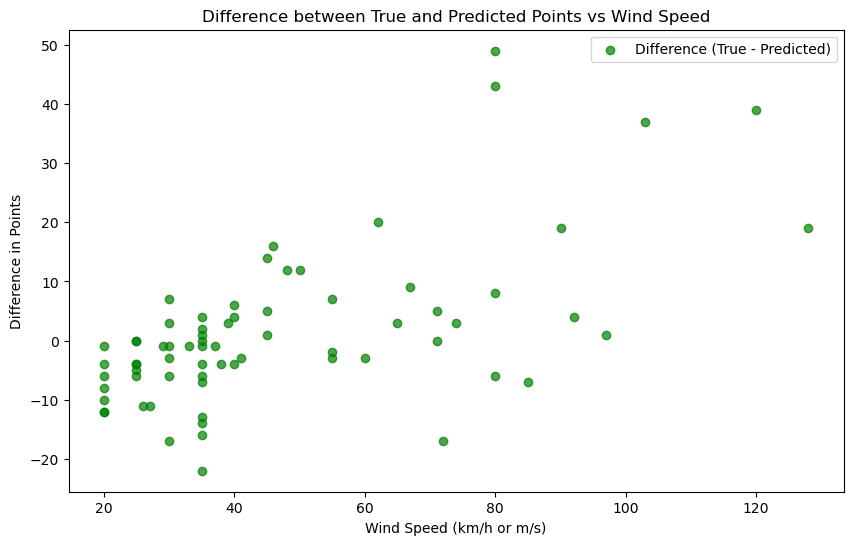

In [26]:
# Performing a Random Sample from our test_labels vs Submission Wind Speed values
y_true_rand = (test_labels['Wind_Speed']).sample(n=70, random_state=42)
y_pred_rand = (submission['Wind_Speed']).sample(n=70, random_state=42)

# Calculating the difference between true and predicted
difference = y_true_rand - y_pred_rand

# Scatter plot of difference vs wind speed
plt.figure(figsize=(10, 6))
plt.scatter(y_true_rand, difference, color='green', label='Difference (True - Predicted)', alpha=0.7)

# Adding titles and labels
plt.title("Difference between True and Predicted Points vs Wind Speed")
plt.xlabel("Wind Speed (km/h or m/s)")
plt.ylabel("Difference in Points")

# Show the legend
plt.legend()

# Show the plot
plt.show()

### Model Composition

In [27]:
# Displaying our model's Summary
storm_model.eval()
summary(storm_model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         ZeroPad2d-1          [-1, 3, 225, 225]               0
Conv2dStaticSamePadding-2         [-1, 32, 112, 112]             864
       BatchNorm2d-3         [-1, 32, 112, 112]              64
MemoryEfficientSwish-4         [-1, 32, 112, 112]               0
         ZeroPad2d-5         [-1, 32, 114, 114]               0
Conv2dStaticSamePadding-6         [-1, 32, 112, 112]             288
       BatchNorm2d-7         [-1, 32, 112, 112]              64
MemoryEfficientSwish-8         [-1, 32, 112, 112]               0
          Identity-9             [-1, 32, 1, 1]               0
Conv2dStaticSamePadding-10              [-1, 8, 1, 1]             264
MemoryEfficientSwish-11              [-1, 8, 1, 1]               0
         Identity-12              [-1, 8, 1, 1]               0
Conv2dStaticSamePadding-13             [-1, 32, 1, 1]             288
         I